In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())            # Numero di GPU disponibili
  print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
  print(torch.cuda.current_device())          # Device in uso al momento
  print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
  print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/CTU_Shuffled/CTU_Shuffled.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DATI***

In [ ]:
dataset = dataset.drop('StartTime', axis=1)

In [ ]:
dataset

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,<->,CON,0.0,0.0,2,131,71,flow=Background-UDP-Established,normal
1,0.014909,2,->,SRPA_FSPA,0.0,0.0,11,2882,1504,flow=Background-TCP-Established,normal
2,0.000798,1,<->,CON,0.0,0.0,2,244,182,flow=Background-UDP-Established,normal
3,15.302759,1,->,INT,0.0,NaN,4,336,336,flow=Background-UDP-Attempt,normal
4,7.843942,2,->,FSPA_SRPA,0.0,0.0,93,11846,4562,flow=Background-TCP-Established,normal
...,...,...,...,...,...,...,...,...,...,...,...
31468,8.917003,2,->,S_SA,0.0,0.0,8,512,194,flow=Background-TCP-Established,normal
31469,0.038780,1,<->,CON,0.0,0.0,2,191,68,flow=To-Background-UDP-CVUT-DNS-Server,normal
31470,603.106201,1,->,INT,0.0,NaN,6,552,552,flow=Background-Attempt-cmpgw-CVUT,normal
31471,0.000550,1,<->,CON,0.0,0.0,2,128,60,flow=Background-UDP-Established,normal


In [ ]:
print(Counter(dataset['multilabel']))

Counter({'normal': 31406, 'BotNet': 67})


In [ ]:
dep_var = 'multilabel'

cont_names = [col for col in dataset.columns if col != dep_var]

print(cont_names, 'len: ', len(cont_names))

['Dur', 'Proto', 'Dir', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Details'] len:  10


In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in ["Dir", "State", "Details"]:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

# Fill NaN
""" Eliminiamo dalle colonne i valori nan """ 
for col in dataset.columns:
  dataset[col] = dataset[col].fillna(0)


In [ ]:
dataset.head()

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,3,4,0.0,0.0,2,131,71,6,1
1,0.014909,2,0,89,0.0,0.0,11,2882,1504,4,1
2,0.000798,1,3,4,0.0,0.0,2,244,182,6,1
3,15.302759,1,0,53,0.0,0.0,4,336,336,5,1
4,7.843942,2,0,43,0.0,0.0,93,11846,4562,4,1


In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=(2500/len(train)), random_state=0)

In [ ]:
"""Visto che nel dataset la variabile target è molto squilibrata lo amplio con una generazione
 randomica di dati mediante la tecnica chiamata Synthetic Minority Over-sampling Technique (SMOTE)"""

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_sm, y_train = sm.fit_resample(train, y_train)
train = pd.DataFrame(x_sm,columns=train.columns)

In [ ]:
#y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [ ]:
test

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
11058,0.065865,2,0,109,0.0,0.0,16,1270,0,4
18577,0.000353,1,3,4,0.0,0.0,2,224,87,46
11688,0.000369,1,3,4,0.0,0.0,2,264,83,46
20637,0.118549,1,3,4,0.0,0.0,2,133,73,6
30734,0.000614,1,3,4,0.0,0.0,2,237,175,6
...,...,...,...,...,...,...,...,...,...,...
27164,0.001956,1,3,4,0.0,0.0,2,522,462,6
3371,0.000371,1,3,4,0.0,0.0,2,422,72,46
31171,0.020569,1,3,4,0.0,0.0,2,209,72,46
2419,0.000214,1,3,4,0.0,0.0,2,214,81,46


In [ ]:
train

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
0,0.190620,1.0,3.0,4.0,0.0,0.0,2.000000,577.000000,78.000000,2.0
1,756.997742,1.0,3.0,4.0,0.0,0.0,6.000000,438.000000,213.000000,6.0
2,0.000866,1.0,3.0,4.0,0.0,0.0,2.000000,320.000000,64.000000,6.0
3,0.000844,1.0,3.0,4.0,0.0,0.0,2.000000,135.000000,75.000000,6.0
4,0.000359,1.0,3.0,4.0,0.0,0.0,2.000000,368.000000,90.000000,37.0
...,...,...,...,...,...,...,...,...,...,...
26411,79.045345,2.0,0.0,92.0,0.0,0.0,63.798394,47535.545542,2956.798180,27.0
26412,0.663930,1.0,3.0,4.0,0.0,0.0,2.000000,286.102429,73.170553,35.0
26413,1.442241,2.0,0.0,37.0,0.0,0.0,10.000000,1329.000000,842.845422,28.0
26414,0.006586,1.0,3.0,4.0,0.0,0.0,2.000000,274.388544,74.018529,35.0


In [ ]:
validation

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
22555,0.000588,1,3,4,0.0,0.0,2,132,72,6
9717,0.000642,1,3,4,0.0,0.0,2,237,163,6
5155,6.189429,1,0,53,0.0,0.0,3,300,300,1
813,0.000391,1,3,4,0.0,0.0,2,208,79,46
19029,0.000429,1,3,4,0.0,0.0,2,424,75,46
...,...,...,...,...,...,...,...,...,...,...
26303,0.000286,1,3,4,0.0,0.0,2,261,84,46
14925,0.000246,1,3,4,0.0,0.0,2,222,75,46
3675,1137.244873,1,3,4,0.0,0.0,6,660,242,6
9314,0.000280,1,3,4,0.0,0.0,2,214,81,46


### ***MODEL***

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class CTU_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = CTU_Dataset(train, y_train)
valid_ds = CTU_Dataset(validation, y_val)

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
class CTUModel(nn.Module):
    def __init__(self, n_cont):
        super().__init__()
        self.n_cont =  n_cont
        self.lin1 = nn.Linear(self.n_cont, 200)
        self.lin2 = nn.Linear(200, 100)
        self.lin3 = nn.Linear(100, 2)
        self.bn1 = nn.BatchNorm1d(self.n_cont, momentum=1.0)
        self.bn2 = nn.BatchNorm1d(200, momentum=1.0)
        self.bn3 = nn.BatchNorm1d(100, momentum=1.0)
        self.drops = nn.Dropout(0.00001)
        

    def forward(self, x_cont):
        x = self.bn1(x_cont)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print('ep ', i, " training loss: ", loss)
        val_loss(model, valid_dl)

### ***TRAINING***

In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """ 

batch_size = 4096
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [ ]:
model = CTUModel(len(cont_names))
to_device(model, device)

CTUModel(
  (lin1): Linear(in_features=10, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=2, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (drops): Dropout(p=1e-05, inplace=False)
)

In [ ]:
train_loop(model, epochs=500, lr=0.00008)

ep  0  training loss:  0.8499145677853612
valid loss  1.2395600080490112  and accuracy  0.4668
ep  1  training loss:  0.6552046706718362
valid loss  1.3511760234832764  and accuracy  0.8312
ep  2  training loss:  0.5256479240994537
valid loss  0.5532494187355042  and accuracy  0.876
ep  3  training loss:  0.4489174076169278
valid loss  0.4461265504360199  and accuracy  0.8932
ep  4  training loss:  0.3949977989307972
valid loss  0.3547188341617584  and accuracy  0.9672
ep  5  training loss:  0.3538499389143874
valid loss  0.2990839183330536  and accuracy  0.9732
ep  6  training loss:  0.32168781670709584
valid loss  0.27296939492225647  and accuracy  0.9704
ep  7  training loss:  0.29530577755999665
valid loss  0.2625962197780609  and accuracy  0.9744
ep  8  training loss:  0.266379399273628
valid loss  0.26685795187950134  and accuracy  0.9672
ep  9  training loss:  0.24917330736828025
valid loss  0.6821154952049255  and accuracy  0.9612
ep  10  training loss:  0.2354766972890989
vali

### ***PREDICTION***

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = CTU_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        out = model(x)
        prob = F.softmax(out, dim=1)
        preds.append(prob)

In [ ]:
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

### ***EVALUATION***

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({1: 15702, 0: 35})
Pred: Counter({1: 15695, 0: 42})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

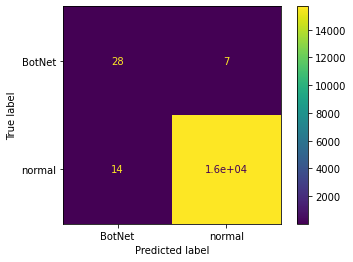

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'BotNet' : 0,
               'normal' : 1}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[15688    14]
  [    7    28]]

 [[   28     7]
  [   14 15688]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   28 15688]
True negative:  [15688    28]
False positive:  [14  7]
False negative:  [ 7 14]
True positive rate:  [0.8        0.99910839]
True negative rate:  [0.99910839 0.8       ]
False positive rate:  [0.00089161 0.2       ]
False negative rate:  [0.2        0.00089161]


In [ ]:
print(cm)

[[   28     7]
 [   14 15688]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        35
           1       1.00      1.00      1.00     15702

    accuracy                           1.00     15737
   macro avg       0.83      0.90      0.86     15737
weighted avg       1.00      1.00      1.00     15737



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9986655652284425
Precision_weighted:  0.9988136373717961
Recall_weighted:  0.9986655652284425
mcc:  0.7296454792242311
f2:  0.9986951761447848
